In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
import torchvision.transforms.functional as TF
import torchvision
from torch.utils.data import DataLoader, random_split
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import zipfile
import random
from google.colab import drive
import os



In [2]:
# Setting seed for reproducibility

def set_seed(seed=42):
    # Python built-in RNG
    random.seed(seed)

    # NumPy RNG
    np.random.seed(seed)

    # PyTorch RNG
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU

    # For deterministic behavior (slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)


set_seed(42)

In [3]:
# Set up device (is available use GPU to speed up computations)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
drive.mount('/content/drive')
path='/content/drive/My Drive/DLSS/EuroSAT_RGB.zip'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Where to extract the files
extract_to = '/content/extracted_data'

# Create the directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Extract
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [98]:
# Minimal transform just for initial loading
transform = transforms.Compose([
    transforms.ToTensor()  # This is required for visualizing images initially
])

# Importing the data
euroSat = datasets.ImageFolder(root='extracted_data/EuroSAT_RGB', transform=transform)

# Checking for uniform shape of images (uncomment if needs to be checked again)
# shapes = set()
# for img, label in euroSat:
#     shapes.add(img.shape)
# print(shapes)

image_shape=euroSat[0][0].shape

# Defining train/test size
train_size = int(0.85 * len(euroSat))
test_size = len(euroSat) - train_size

#Splitting into train/test set
euroSat_train, euroSat_test = random_split(euroSat, [train_size, test_size])

# Storing data in PyTorch DataLoader
train_loader = DataLoader(euroSat_train, batch_size=4, shuffle=True, num_workers=2,worker_init_fn=seed_worker,generator=g)
test_loader = DataLoader(euroSat_test, batch_size=4, shuffle=False, num_workers=2,worker_init_fn=seed_worker,generator=g)

# Extract and pring image classes
classes = euroSat.classes
print(classes)
print(image_shape)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
torch.Size([3, 64, 64])


Sample images:


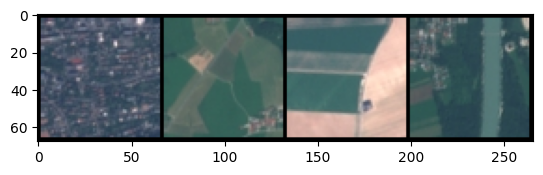

Labels: Residential  Pasture      AnnualCrop   River       


In [105]:
# Function to show images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

print('Sample images:')
imshow(torchvision.utils.make_grid(images))
print('Labels:', ' '.join(f'{classes[labels[j]]:12s}' for j in range(4)))

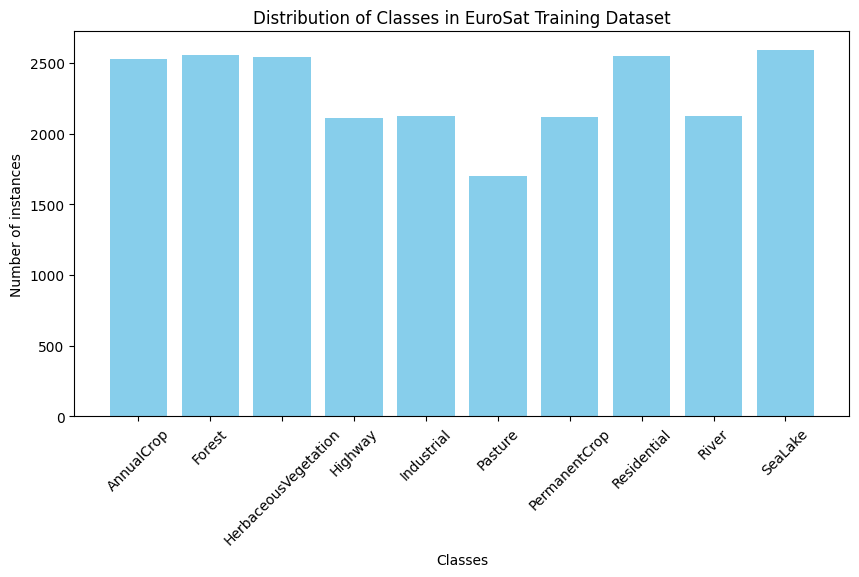

In [8]:
# Plot the distribution of classes in the training dataset (uncomment if need to be done again, takes a while)
class_counts = {class_name: 0 for class_name in classes}
for _, label in euroSat_train:
    class_name = classes[label]
    class_counts[class_name] += 1

# Visualization of the class distribution
plt.figure(figsize=(10,5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of instances')
plt.title('Distribution of Classes in EuroSat Training Dataset')
plt.xticks(rotation=45)
plt.show()

In [9]:

# Define transformations for training and testing

# Non-augmented transformation of training data
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# Augmented transformation of training data
train_transform_augment = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
   transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))
])

# Non-augmented transformation, i.e. normalization of test data
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])


# Determining validation split
validation_split = 15/85

# Training size and validation size
train_size = int((1 - validation_split) * len(euroSat_train))
validation_size = len(euroSat) - train_size

# Splitting training data in validation and training set
euroSat_train, euroSat_val = random_split(euroSat, [train_size, validation_size])

# Apply appropriate transformations to each dataset
#euroSat_train.dataset.transform = train_transform  # Non-augmented training data
euroSat_train.dataset.transform = train_transform_augment  # Augmented training data

euroSat_val.dataset.transform = test_transform  # Non-augmented for validation
euroSat_test.transform=test_transform

# Display sizes of each dataset
print(f"Training Data: {len(euroSat_train)} samples")
print(f"Validation Data: {len(euroSat_val)} samples")
print(f"Test Data: {len(euroSat_test)} samples")

Training Data: 18900 samples
Validation Data: 8100 samples
Test Data: 4050 samples


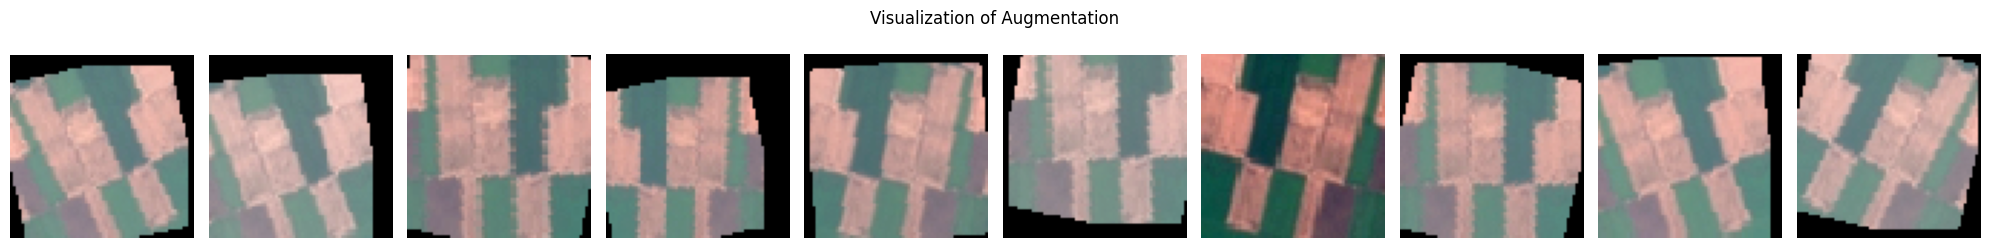

In [10]:

def visualize_single_image_augmentations(image, transform, repetitions=10):
    fig, axes = plt.subplots(1, repetitions, figsize=(20, 3))
    fig.suptitle("Visualization of Augmentation", fontsize=12, y=0.9)
    for i in range(repetitions):
        # Apply the augmentation transform each time
        img = transform(image)
        # Convert tensor to numpy and permute to (H, W, C)
        img = img.permute(1, 2, 0).numpy()
        # Normalize to 0–1 for display
        img = (img - img.min()) / (img.max() - img.min())
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Load a single image from EuroSAT without any transform
original_image, _ = datasets.ImageFolder(root='extracted_data/EuroSAT_RGB', transform=None)[random.randint(1, 10000)]

# Define augmentation transform for RGB images
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))
])

# Visualize different augmentations of the same image
visualize_single_image_augmentations(original_image, augmentation_transform)

In [11]:
#EARLY STOPPING AND TRAINING FUCNTIONS

# Defining early stopping mechanism with a patience of 25 epochs and a minimum change in validation loss of 0.0001
class EarlyStopping:
    def __init__(self, patience=25, min_delta=0.0001, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path  # Path to save the best model

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < self.best_loss:
                self.save_checkpoint(val_loss, model)
                self.best_loss = val_loss
                self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')


# Defining generic model training function
def train_model(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch: {epoch+1}, Training Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')

        # Early stopping call and pass the model for checkpointing
        early_stopper(val_loss / len(val_loader), model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    # Load the best model weights
    model.load_state_dict(torch.load('checkpoint.pt'))
    return train_losses, val_losses

# Defining CNN training function
def train_cnn_model(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            # Get only the logits from the model's output which is the first element of the tuple
            output, _ = model(data)  # Adjust here to unpack the tuple and ignore the second output
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                # Again, get only the logits when evaluating
                output, _ = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch: {epoch+1}, Training Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')

        # Early stopping call and pass the model for checkpointing
        early_stopper(val_loss / len(val_loader), model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    # Load the best model weights
    model.load_state_dict(torch.load('checkpoint.pt'))
    return train_losses, val_losses


In [12]:
# Defining the MLP architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(image_shape[0]*image_shape[1]*image_shape[2], 512),  # Adjusted input layer to match 3-channel 64x64 size
            nn.ReLU(),
            nn.Dropout(0.5),  # Adding dropout for regularization
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),  # Another dropout layer
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, len(classes)),  # Output layer for 10 classes
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.network(x)

# Instantiate the model and move it to the available device
MLP_img = MLP().to(device)
summary(MLP_img, input_size=image_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 12288]               0
            Linear-2                  [-1, 512]       6,291,968
              ReLU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
              ReLU-6                  [-1, 256]               0
           Dropout-7                  [-1, 256]               0
            Linear-8                  [-1, 128]          32,896
              ReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
Total params: 6,457,482
Trainable params: 6,457,482
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.11
Params size (MB): 24.63
Estima

Epoch: 1, Training Loss: 1.9443, Validation Loss: 1.7415
Validation loss decreased (1.741524 --> 1.741524).  Saving model ...
Epoch: 2, Training Loss: 1.6556, Validation Loss: 1.4709
Validation loss decreased (1.741524 --> 1.470885).  Saving model ...
Epoch: 3, Training Loss: 1.4809, Validation Loss: 1.3468
Validation loss decreased (1.470885 --> 1.346784).  Saving model ...
Epoch: 4, Training Loss: 1.4052, Validation Loss: 1.2955
Validation loss decreased (1.346784 --> 1.295527).  Saving model ...
Epoch: 5, Training Loss: 1.3568, Validation Loss: 1.2776
Validation loss decreased (1.295527 --> 1.277619).  Saving model ...
Epoch: 6, Training Loss: 1.3210, Validation Loss: 1.2431
Validation loss decreased (1.277619 --> 1.243105).  Saving model ...
Epoch: 7, Training Loss: 1.3078, Validation Loss: 1.2410
Validation loss decreased (1.243105 --> 1.241000).  Saving model ...
Epoch: 8, Training Loss: 1.3190, Validation Loss: 1.2516
Epoch: 9, Training Loss: 1.2892, Validation Loss: 1.2098
Vali

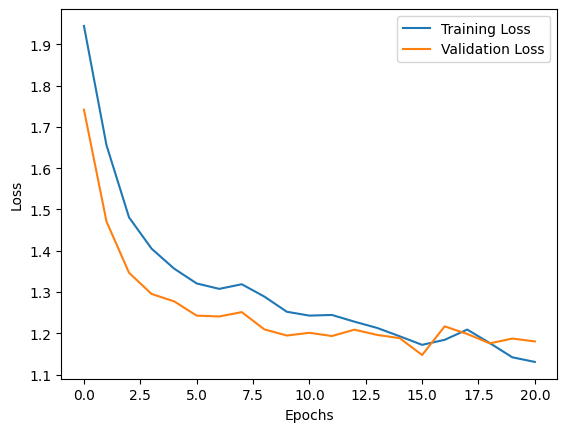

In [13]:
# Preparing hyperparameters and training MLP

# Batch Size of 512 images
batch_size = 512
# Training for 30 epochs
epochs = 50
# Patience of 5 epochs
patience = 5
# Learning Rate
lr = 0.001
# Regularization parameter (L2, i.e. weight decay) toprevent overfitting
reg = 0.001

# Create DataLoaders for training, validation, and testing
train_loader = DataLoader(euroSat_train, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker,generator=g)
validation_loader = DataLoader(euroSat_val, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker,generator=g)
test_loader = DataLoader(euroSat_test, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker,generator=g)


# MLP model, criterion, optimizer, and early stopping initialization
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(MLP_img.parameters(), lr=lr, weight_decay=reg)  # L2 regularization
early_stopper = EarlyStopping(patience=patience)

# Training the model
train_losses, val_losses = train_model(epochs, MLP_img, optimizer, criterion, train_loader, validation_loader, early_stopper)

# Plotting the training and validation losses
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# Defining the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            # Input: (3, 64, 64), i.e. 3-channel, 64x64 input

            # First Convolutional Layer: --> (32,64,64)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),

            # Second Convolutional Layer: -->(32,64,64)
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),

            # First Pooling and Dropout: --> (32,32,32)
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            # Third Convolutional Layer: -->(64,32,32)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),

            # Fourth Convolutional Layer: --> (64,32,32)
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),

            # Second Pooling and Droput: --> (64, 16,16)
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            # Fith Convolutional Layer: --> (128,16,16)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),

            # Sixth Convolutional Layer: --> (128,16,16)
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),

            # Third Pooling and Dropout:--> (128,8,8)
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)

        )

        # Classifier
        self.classifier = nn.Sequential(
            # Flatten (128,8,8) --> 16384
            nn.Flatten(),
            # Fully connected Layer
            nn.Linear(128 * 8 * 8, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            # Output Layer
            nn.Linear(64, 10))

    def forward(self, x):
        x = self.features(x)
        last_conv_output = x
        x = self.classifier(x)
        return x, last_conv_output

# Instantiate and summarize the model
CNN_img = CNN().to(device)
summary(CNN_img, input_size=image_shape)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 32, 64, 64]           9,248
              ReLU-4           [-1, 32, 64, 64]               0
         MaxPool2d-5           [-1, 32, 32, 32]               0
           Dropout-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          18,496
              ReLU-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,928
             ReLU-10           [-1, 64, 32, 32]               0
        MaxPool2d-11           [-1, 64, 16, 16]               0
          Dropout-12           [-1, 64, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]          73,856
             ReLU-14          [-1, 128,

Epoch: 1, Training Loss: 2.0588, Validation Loss: 1.8246
Validation loss decreased (1.824617 --> 1.824617).  Saving model ...
Epoch: 2, Training Loss: 1.6979, Validation Loss: 1.3761
Validation loss decreased (1.824617 --> 1.376084).  Saving model ...
Epoch: 3, Training Loss: 1.4503, Validation Loss: 1.2193
Validation loss decreased (1.376084 --> 1.219294).  Saving model ...
Epoch: 4, Training Loss: 1.2671, Validation Loss: 1.0723
Validation loss decreased (1.219294 --> 1.072286).  Saving model ...
Epoch: 5, Training Loss: 1.1636, Validation Loss: 0.9501
Validation loss decreased (1.072286 --> 0.950144).  Saving model ...
Epoch: 6, Training Loss: 1.0568, Validation Loss: 0.8325
Validation loss decreased (0.950144 --> 0.832507).  Saving model ...
Epoch: 7, Training Loss: 0.9630, Validation Loss: 0.8135
Validation loss decreased (0.832507 --> 0.813526).  Saving model ...
Epoch: 8, Training Loss: 0.8976, Validation Loss: 0.6828
Validation loss decreased (0.813526 --> 0.682770).  Saving mo

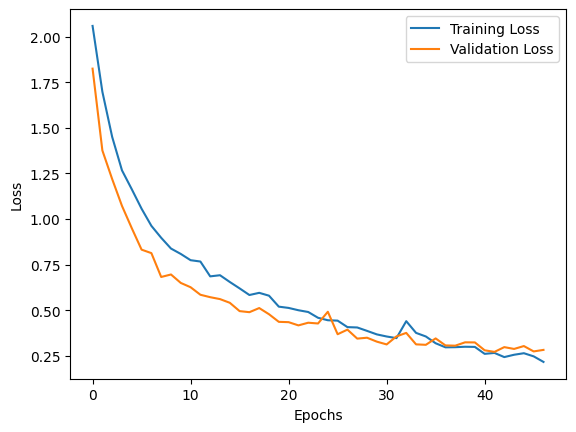

In [15]:
# Same hyperparameters as MLP
batch_size = 512
epochs = 50
patience = 5
lr = 0.001
reg = 0.001

# Create DataLoaders for training, validation, and testing
train_loader = DataLoader(euroSat_train, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker,generator=g)
validation_loader = DataLoader(euroSat_val, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker,generator=g)
test_loader = DataLoader(euroSat_test, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker,generator=g)


#CNN model, criterion, optimizer, and early stopping initialization
criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.AdamW(CNN_img.parameters(), lr=lr, weight_decay=reg)
early_stopper = EarlyStopping(patience=patience)

# Training the model
train_losses, val_losses = train_cnn_model(epochs, CNN_img, cnn_optimizer, criterion, train_loader, validation_loader, early_stopper)

# Plotting the training and validation losses
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

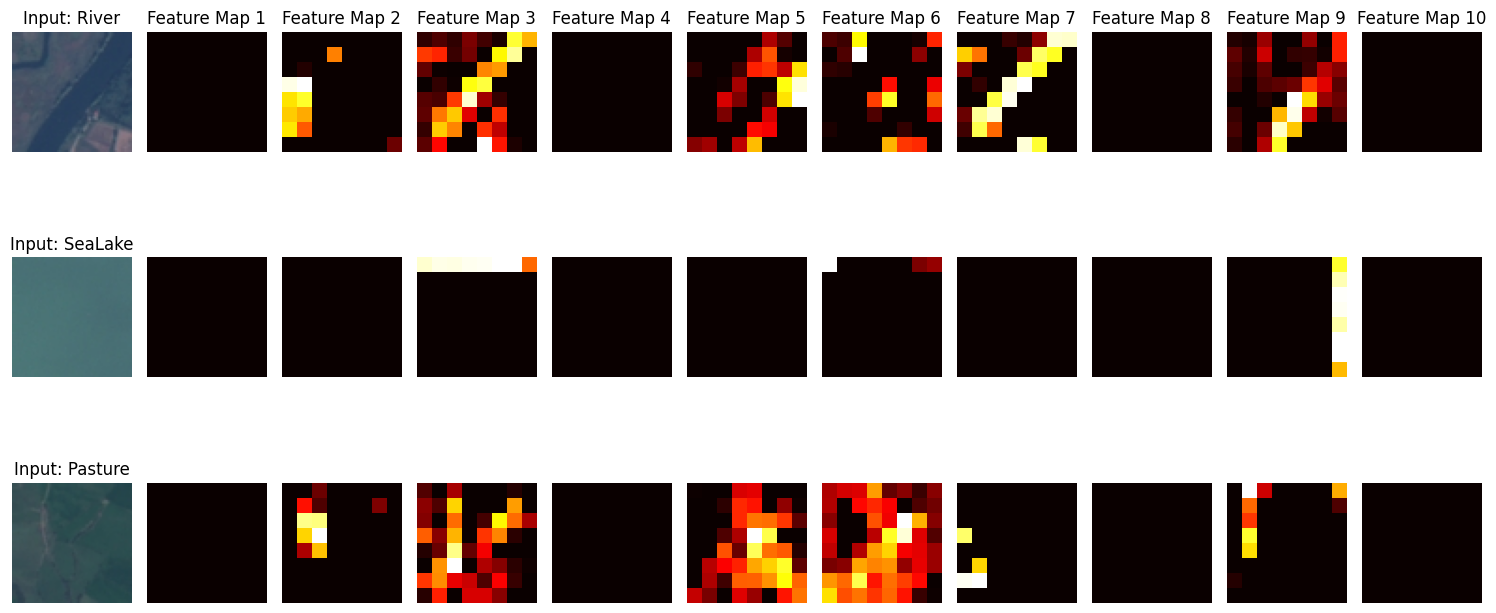

In [56]:

def denormalize(tensor, mean, std):
    """
    Denormalizes a tensor image that was normalized with the given mean and std.
    Args:
      tensor: torch.Tensor of shape (C, H, W)
      mean: list or tuple of means for each channel
      std: list or tuple of stds for each channel
    Returns:
      Denormalized tensor (still torch.Tensor)
    """
    denorm = tensor.clone()
    for t, m, s in zip(denorm, mean, std):
        t.mul_(s).add_(m)
    return denorm

def visualize_features_and_inputs(model, data_loader, class_names, num_images=5, num_maps=5, mean=[0.5]*3, std=[0.5]*3):
    model.eval()
    fig, axes = plt.subplots(num_images, num_maps + 1, figsize=(15, 2.5 * num_images))

    data_iter = iter(data_loader)
    for idx in range(num_images):
        images, labels = next(data_iter)
        images = images.to(device)

        _, feature_maps = model(images)
        feature_maps = feature_maps.cpu().data

        # Denormalize and display input image
        img = denormalize(images[idx].cpu(), mean, std)
        img = img.permute(1, 2, 0)
        img = torch.clamp(img, 0, 1)

        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title(f'Input: {class_names[labels[idx]]}')
        axes[idx, 0].axis('off')

        # Display selected feature maps
        for i in range(num_maps):
            if i < feature_maps.size(1):
                fmap = feature_maps[idx, i]
                fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-5)
                axes[idx, i + 1].imshow(fmap, cmap='hot')
                axes[idx, i + 1].set_title(f'Feature Map {i+1}' if idx == 0 else '')
                axes[idx, i + 1].axis('off')
            else:
                axes[idx, i + 1].axis('off')

    plt.tight_layout()
    plt.savefig('feature_maps_visualization.png', dpi=300)
    plt.show()


# Call the visualization function on the training data specifying the number of images and feature maps
visualize_features_and_inputs(CNN_img, train_loader, classes, num_images=3, num_maps=10)

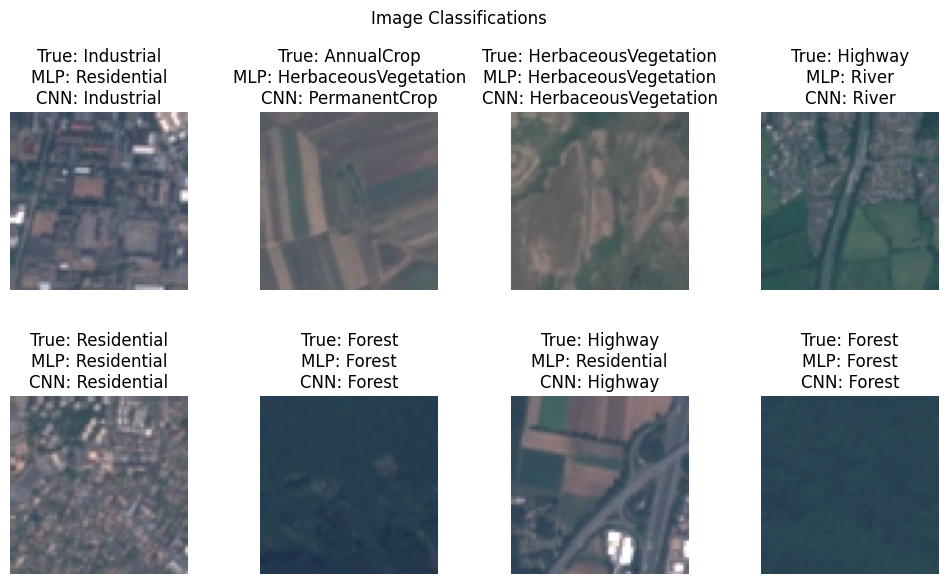

In [96]:

# Assuming the models (MLP and CNN) and device setup are already defined and imported

# Function to display images and labels
def imshow(img, ax, title):
    img = img / 2 + 0.5  # unnormalize if normalization was applied
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    ax.set_title(title)
    ax.axis('off')

# Put models in evaluation mode
MLP_img.eval()
CNN_img.eval()

# Numer of images to show
N_samples = 8

# DataLoader setup
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

test_loader = DataLoader(euroSat_test, batch_size=N_samples, shuffle=True, worker_init_fn=seed_worker,generator=g)

# Fetch images and labels
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Move images to device
images = images.to(device)
labels = labels.to(device)

# Get predictions from both models
with torch.no_grad():
    outputs_mlp = MLP_img(images)
    _, predicted_mlp = torch.max(outputs_mlp, 1)

    outputs_cnn,_ = CNN_img(images)
    _, predicted_cnn = torch.max(outputs_cnn, 1)

# EuroSAT classes
classes = classes


# Setup matplotlib figures
n_cols = 4  # Number of images per row
n_rows = (N_samples + n_cols - 1) // n_cols  # Ceiling division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
axes = axes.flatten()  # Make indexing easier
images = images.cpu()
labels = labels.cpu()
predicted_mlp = predicted_mlp.cpu()
predicted_cnn = predicted_cnn.cpu()

# Display each image
for i in range(N_samples):
    ax = axes[i]
    imshow(images[i], ax, f"True: {classes[labels[i]]}\nMLP: {classes[predicted_mlp[i]]}\nCNN: {classes[predicted_cnn[i]]}")

plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.suptitle("Image Classifications", y=1.05)

plt.show()


---------------MLP MODEL---------------

Accuracy: 0.6483950617283951
Classification Report:
                       precision    recall  f1-score   support

          AnnualCrop     0.6031    0.6631    0.6317       472
              Forest     0.7965    0.8235    0.8098       442
HerbaceousVegetation     0.6158    0.4760    0.5369       458
             Highway     0.5455    0.1995    0.2921       391
          Industrial     0.8811    0.8624    0.8717       378
             Pasture     0.5731    0.8127    0.6722       299
       PermanentCrop     0.6412    0.5092    0.5676       379
         Residential     0.5144    0.7956    0.6248       450
               River     0.5493    0.6533    0.5968       375
             SeaLake     0.8471    0.7094    0.7721       406

            accuracy                         0.6484      4050
           macro avg     0.6567    0.6505    0.6376      4050
        weighted avg     0.6570    0.6484    0.6371      4050



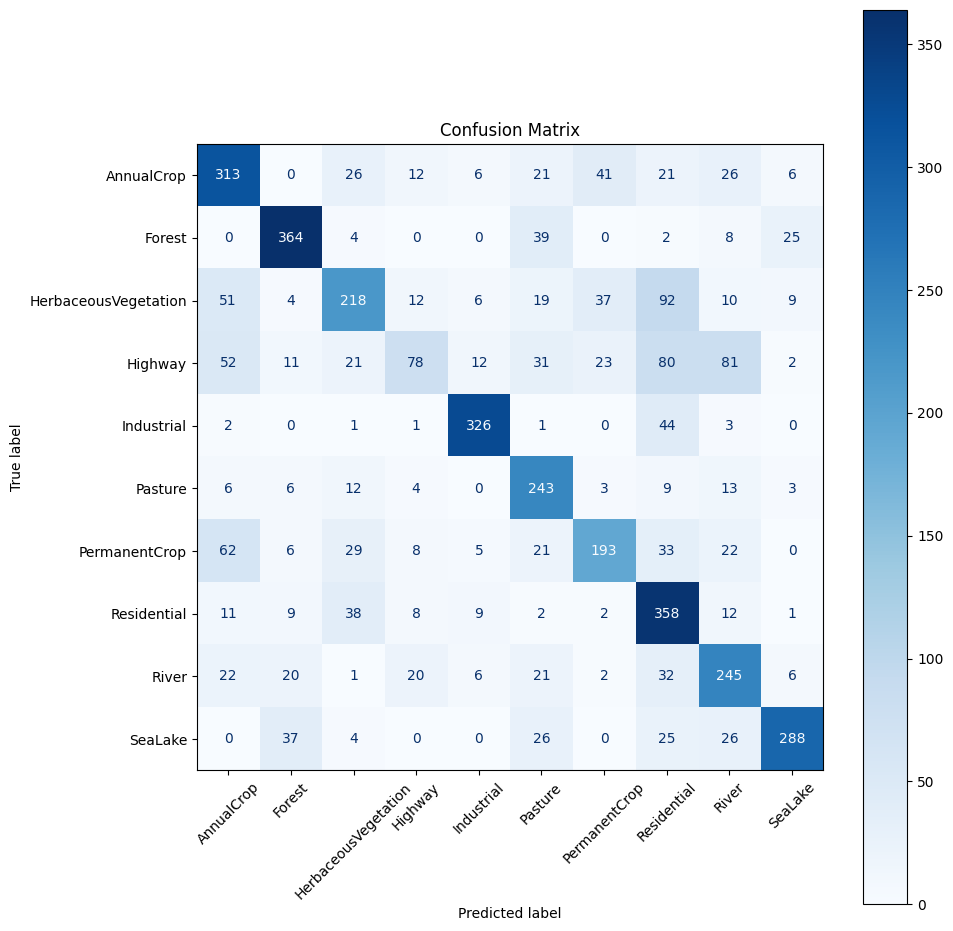


---------------CNN MODEL---------------

Accuracy: 0.9449382716049383
Classification Report:
                       precision    recall  f1-score   support

          AnnualCrop     0.9060    0.9597    0.9321       472
              Forest     0.9707    0.9751    0.9729       442
HerbaceousVegetation     0.9245    0.8821    0.9028       458
             Highway     0.9297    0.9130    0.9213       391
          Industrial     0.9891    0.9603    0.9745       378
             Pasture     0.9331    0.9331    0.9331       299
       PermanentCrop     0.8917    0.9340    0.9124       379
         Residential     0.9672    0.9822    0.9746       450
               River     0.9634    0.9120    0.9370       375
             SeaLake     0.9805    0.9901    0.9853       406

            accuracy                         0.9449      4050
           macro avg     0.9456    0.9442    0.9446      4050
        weighted avg     0.9454    0.9449    0.9449      4050



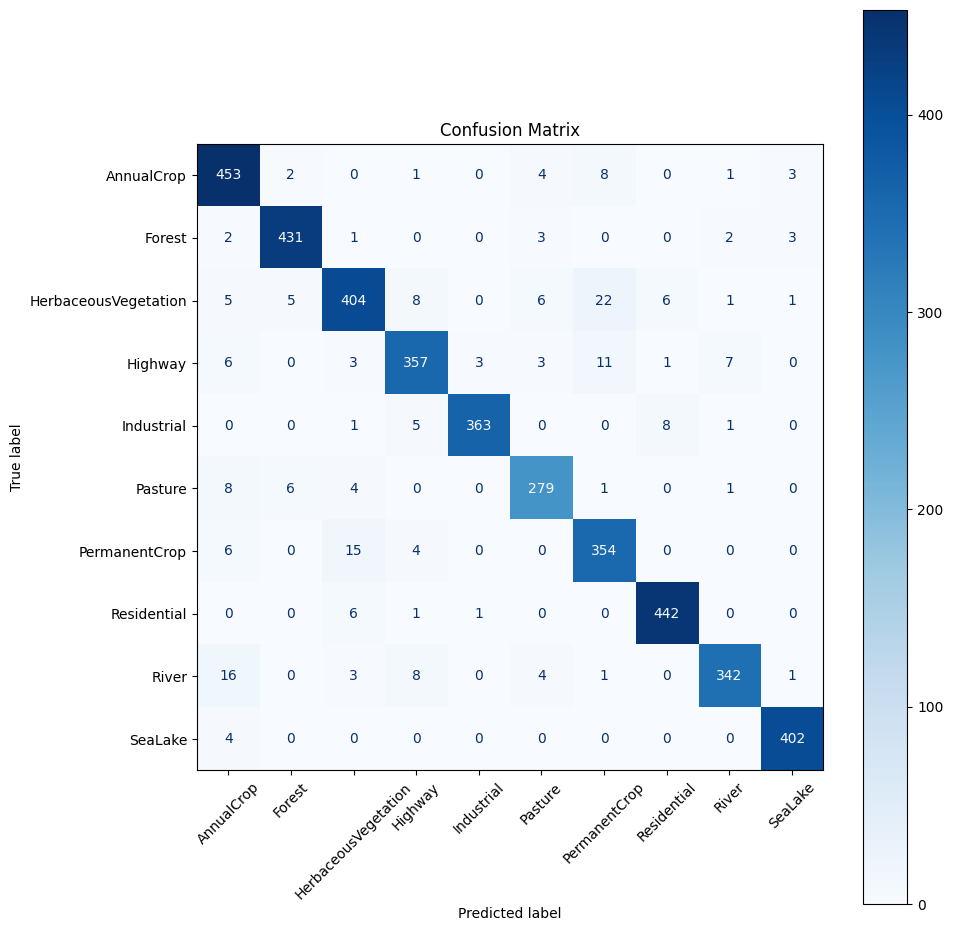

In [59]:

# Function to evaluate the model on the validation set
def evaluate_model(data_loader, model, class_labels=None, title="Confusion Matrix"):
    model.eval()
    y_true = []
    y_preds = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            _, predicted = torch.max(outputs, 1)
            y_preds.extend(predicted.view(-1).cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    accuracy = accuracy_score(y_true, y_preds)
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(
        y_true, y_preds, target_names=class_labels, digits=4
    ))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_preds)

    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return accuracy

test_loader = DataLoader(euroSat_test, batch_size=N_samples, shuffle=True, worker_init_fn=seed_worker,generator=g)

# Assuming `model` (MLP) and `cnn_model` are already defined and imported correctly
# Evaluate MLP model
print("\n---------------MLP MODEL---------------\n")
mlp_accuracy = evaluate_model(test_loader, MLP_img, class_labels=classes)
# Evaluate CNN model
print("\n---------------CNN MODEL---------------\n")
cnn_accuracy = evaluate_model(test_loader, CNN_img, class_labels=classes)